# Прогнозирование температуры звезды

Задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
Закон смещения Вина.
Закон Стефана-Больцмана.
Спектральный анализ.
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики:

Относительная светимость L/Lo — светимость звезды относительно Солнца.

Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.

Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

Тип звезды.
Тип звезды	Номер, соответствующий типу:

 - Коричневый карлик	0
 
 - Красный карлик	1
 
 - Белый карлик	2
 
 - Звёзды главной последовательности	3
 
 - Сверхгигант	4
 
 - Гипергигант	5
 
Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

### Импортируем необходимые нам библиотеки и функции

In [1]:
!pip install -q  torch
!pip install -q skorch

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import random


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder


import os


from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit 

from skorch import NeuralNetRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

In [3]:
RANDOM_STATE = 12

### Напишем функцию для получения информации о датасете (вывод первых пяти срок, общей информации методом info(), описания информации в столбцах методом discribe(), построение гистограмм для визуализации распределения данных в столбцах), наличия явных дубликатов, построения матрицы корреляции с визуализацией в seaborn.

In [4]:
def get_info(data):
    display('Вывод первых 5-ти строк датасета', data.head())
    display(data.info())
    print('Количество явных дубликатов:', data.duplicated().sum())
    display(data.describe())
    data.hist(figsize=(9, 9));
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(data.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', 
                annot_kws={"fontsize":8})
    plt.title('Матирица корреляции Пирсона')

### Cчитываем данные из файла , сохраняем его в переменной df, получаем общую информацию о датафрейме с помощью функции get_info()

'Вывод первых 5-ти строк датасета'

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

Количество явных дубликатов: 0


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


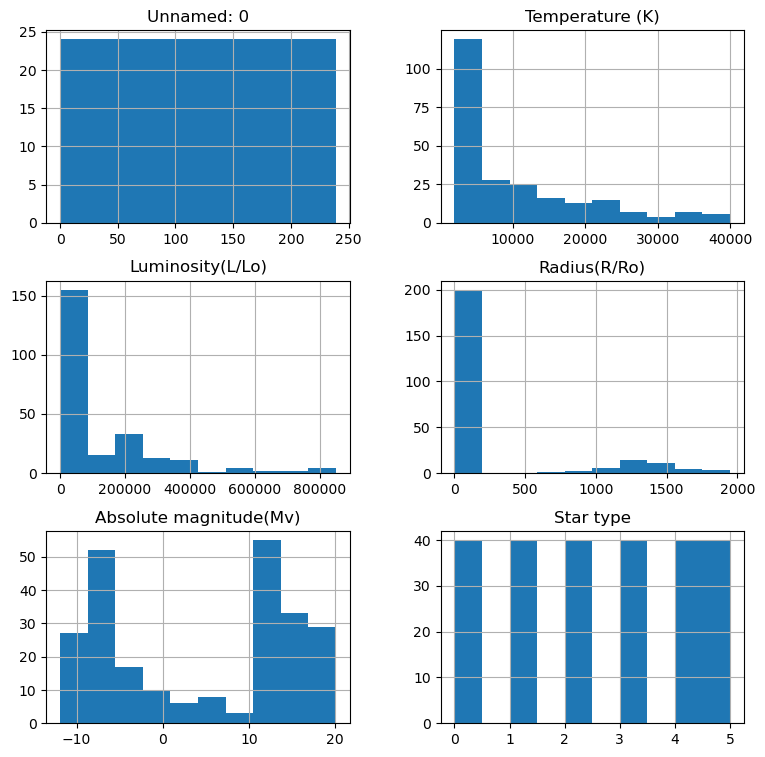

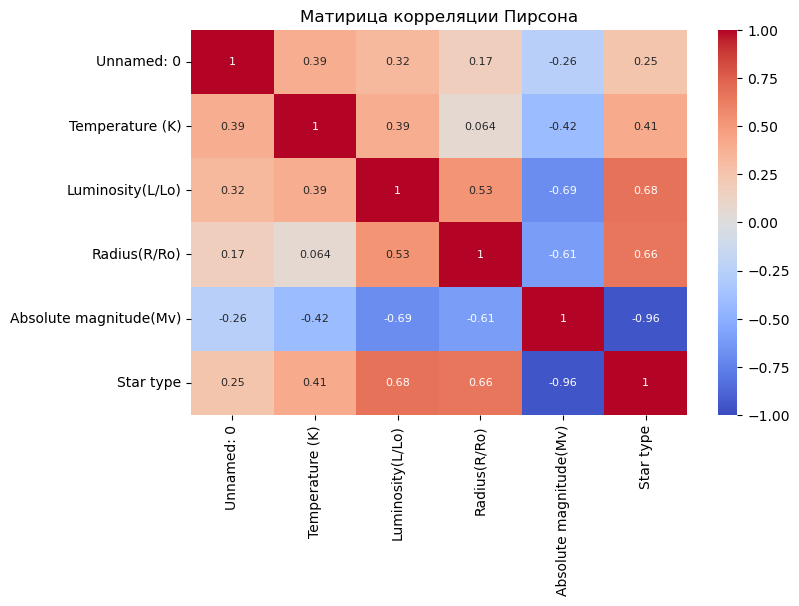

In [5]:
pth1 = '6_class.csv'
pth2 = '/datasets/6_class.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')
get_info(df)    

**Выводы:** Из полученной инфоромации мы видем, что размер дата фрейма - 240 строк на 7 столбцов. Явных дубликатов и пропусков в данных нет. Тип данныйх в столбце Star type необходимо перевести в формат object, т.к. фактически это категориальные данны. Видим, что в дальнейшем можно удалить столбц Unnamed, т.к. он не информативен для дальнейшего обучения нейронной сети. Из матрицы корреляции видно, что есть два мультиколлениарных признака Star type и Absolute magnitude. В столбцах Temperature(K), Luminosity(L/Lo), Radius(R/Ro) - наблюдаются выбросы. Рассмотрим их далее более детально. Распределение количественных признаков не относитсмя к нормальномую.  Название столбцов лучше изменить, т.к они не соответсвуют правилам написания (убрать пропуски и заменить пропуски на нижнее подчеркивание).

### Изменяем названия столбцов

In [6]:
df.rename(columns = {'Temperature (K)': 'temperature_k', 'Absolute magnitude(Mv)': 'absolute_magnitude_mv',
                    'Star type': 'star_type', 'Star color': 'star_color', 'Luminosity(L/Lo)': 'luminosityr', 'Radius(R/Ro)': 'radius'}, inplace = True )
df.columns

Index(['Unnamed: 0', 'temperature_k', 'luminosityr', 'radius',
       'absolute_magnitude_mv', 'star_type', 'star_color'],
      dtype='object')

### Изменяем тип данных в столбце Star type и Star color

In [7]:
df['star_type'] = df['star_type'].astype('category')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Unnamed: 0             240 non-null    int64   
 1   temperature_k          240 non-null    int64   
 2   luminosityr            240 non-null    float64 
 3   radius                 240 non-null    float64 
 4   absolute_magnitude_mv  240 non-null    float64 
 5   star_type              240 non-null    category
 6   star_color             240 non-null    object  
dtypes: category(1), float64(3), int64(2), object(1)
memory usage: 11.8+ KB


### Удаляем столбец Unnamed: 0 и проверяем еще раз на наличие полных дубликатов

In [9]:
df = df.drop('Unnamed: 0', axis=1)
print('Количество явных дубликатов:', df.duplicated().sum())
df.head()

Количество явных дубликатов: 0


,temperature_k,luminosityr,radius,absolute_magnitude_mv,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


**Итог:**  Изменили тип данных с столбце с типом звезд, убрали из названия столбцов пропуски, удалили столбец Unnamed: 0. 

## Предобработка и анализ данных

### Сначала проанализируеми данные в столбцах с категориальными призначками (star_type,	star_color) и проверимь их на наличие неявных дубликатов.

#### Рассмотри столбец star_type, построим столбчатую диаграмму - тип звезд - количество звезд.

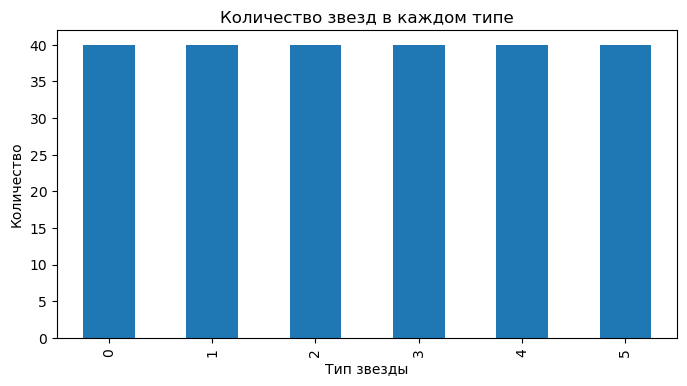

In [10]:
df['star_type'].value_counts().plot.bar(figsize=(8, 4))
plt.title('Количество звезд в каждом типе')
plt.xlabel('Тип звезды')
plt.ylabel('Количество');

**Вывод:**  Всего 6 типов звезд, в каждом типе звез представлено одиниковое количество звезд - 40.

#### Рассмотри столбец star_color. Сначала проверим наличие неявных дубликатов, посмотрев уникальные згначения в данном столбце, при необходимости избавимся от них. Построим столбчатую диаграмму - star_color. - количество звезд.

In [11]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [12]:
df['star_color'] = df['star_color'].str.lower() # приводим к нижнему регистру
df['star_color'] = df['star_color'].str.strip() # удаляем пробелы в начале и конце строки
df['star_color'] = df['star_color'].str.replace(' ', '-') # заменяем пробелы между словами на -
df['star_color'] = df['star_color'].str.replace('white-yellow', 'yellow-white')
df['star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white',
       'pale-yellow-orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'yellowish', 'orange-red'], dtype=object)

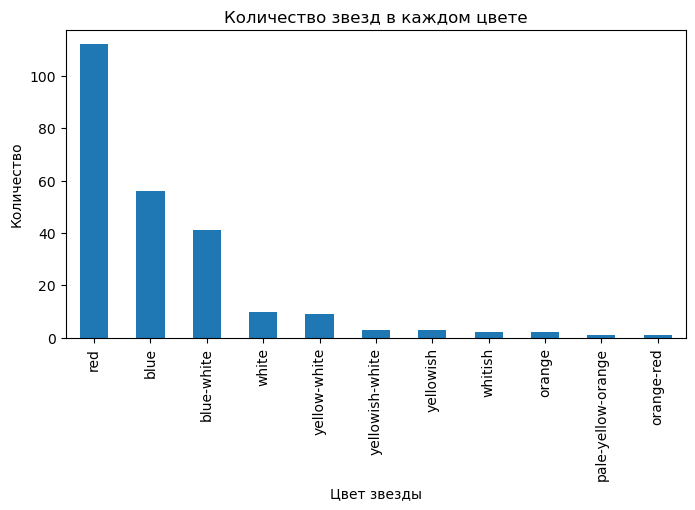

In [13]:
df['star_color'].value_counts().plot.bar(figsize=(8, 4))
plt.title('Количество звезд в каждом цвете')
plt.xlabel('Цвет звезды')
plt.ylabel('Количество');

**Вывод:**  Удалили неявные дубликаты, приведя все названия цветов к нижнему регистру, убрали лишние пробелы, заменили пробелы на - меджду словами. Из графика видно, что наибольшеее количество звезд красных, затем синих(голубых) и бело-голубых, нименьшее количество pale-yellow-orange и orange-red. Данные по этим звездам также оставим, т.к. данных для обучения мало и такие градации цвета есть и по ним также надо предсказывать температуру.

### Рассмотрим более детально целевой признак temperature_K, т.к здесь наблюдаются выбросы справа (температура выше 33 000 К). Постороим коробчатую диаграмму и отберем звезды с температурой выше 33000 К

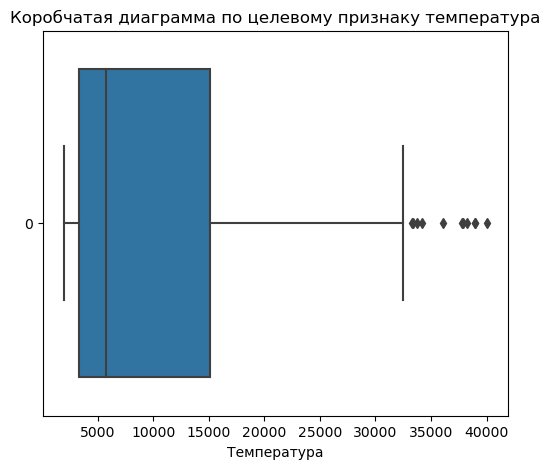

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(data = df['temperature_k'], orient='h')
plt.title('Коробчатая диаграмма по целевому признаку температура')
plt.xlabel('Температура');

In [15]:
df.query('temperature_k > 33000')

,temperature_k,luminosityr,radius,absolute_magnitude_mv,star_type,star_color
30,39000,204000.0,10.60,-4.70,3,blue
49,33750,220000.0,26.00,-6.10,4,blue
99,36108,198000.0,10.20,-4.40,3,blue
100,33300,240000.0,12.00,-6.50,4,blue
101,40000,813000.0,14.00,-6.23,4,blue
109,33421,352000.0,67.00,-5.79,4,blue
159,37800,202900.0,6.86,-4.56,3,blue
214,34190,198200.0,6.39,-4.57,3,blue
231,38234,272830.0,1356.00,-9.29,5,blue
235,38940,374830.0,1356.00,-9.93,5,blue


**Вывод:** Звезд, температура которых превышает 33000, 11. Все эти звезды относятся к синим. Синие звезды по классификации самые горячие звезды, поэтому ошибки в данных нет. Медианное значение температуры составляет - около 5776 К. 

### Рассмотрим более детально целевой признак luminosityr, здесь также наблюдаются выбросы справа. Постороим коробчатую диаграмму и гистограмму.

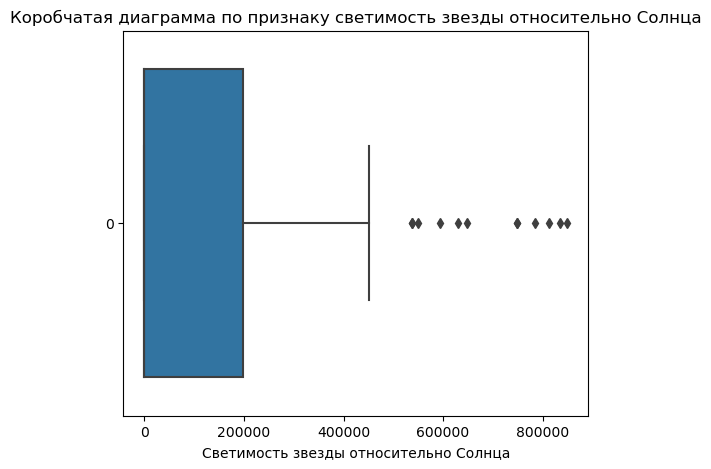

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(data = df['luminosityr'], orient='h')
plt.title('Коробчатая диаграмма по признаку светимость звезды относительно Солнца')
plt.xlabel('Светимость звезды относительно Солнца');

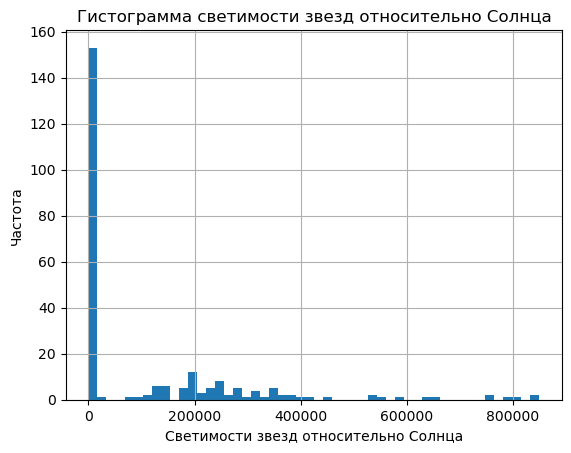

In [17]:
df['luminosityr'].hist(bins= 50)
plt.title('Гистограмма светимости звезд относительно Солнца')
plt.xlabel('Светимости звезд относительно Солнца')
plt.ylabel('Частота');

In [18]:
df.query('luminosityr > 450000')

,temperature_k,luminosityr,radius,absolute_magnitude_mv,star_type,star_color
53,3749,550000.0,1648.0,-8.050,5,orange
101,40000,813000.0,14.0,-6.230,4,blue
162,12675,452000.0,83.0,-5.620,4,blue
172,4287,630000.0,1315.0,-9.200,5,orange
223,23440,537430.0,81.0,-5.975,4,blue
226,9892,593900.0,80.0,-7.262,4,blue
227,10930,783930.0,25.0,-6.224,4,blue
229,21738,748890.0,92.0,-7.346,4,blue
232,32489,648430.0,1948.5,-10.840,5,blue
233,27739,849420.0,1252.0,-7.590,5,blue-white


**Вывод:** Светимость большинства звезд в данных сопоставима со светимостью солнца, медианное значение составляет 0.070500. Наблюдается 'хвост' справа. Значений превышающее значение 450000 - 13, макисмальное - 849420 , оставим данные значения, т.к. такие значения светимости возможны. К тому же высокие значения светимости как раз характерны для звезд с отрицательной абсолютной звёздной величиной, характеризующей блеск звезды.

### Рассмотрим признак radius, здесь также наблюдаются выбросы справа. Постороим коробчатую диаграмму и гистограмму.

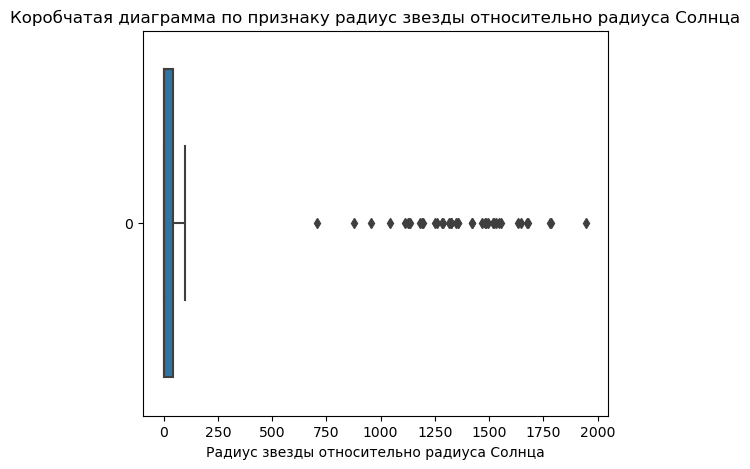

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(data = df['radius'], orient='h')
plt.title('Коробчатая диаграмма по признаку радиус звезды относительно радиуса Солнца')
plt.xlabel('Радиус звезды относительно радиуса Солнца');

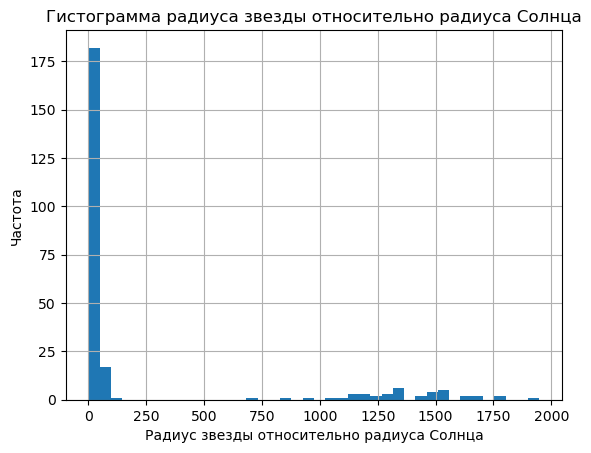

In [20]:
df['radius'].hist(bins= 40)
plt.title('Гистограмма радиуса звезды относительно радиуса Солнца')
plt.xlabel('Радиус звезды относительно радиуса Солнца')
plt.ylabel('Частота');

In [21]:
df.query('radius > 500')

,temperature_k,luminosityr,radius,absolute_magnitude_mv,star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,red
51,3750,283000.0,1260.0,-7.63,5,red
52,3834,272000.0,1183.0,-9.20,5,red
53,3749,550000.0,1648.0,-8.05,5,orange
54,3650,310000.0,1324.0,-7.79,5,red
55,3450,263000.0,1349.0,-11.75,5,red
56,3660,363000.0,1673.0,-11.92,5,red
57,3450,174000.0,1284.0,-11.28,5,red
58,3752,209000.0,955.0,-11.24,5,red
59,3535,195000.0,1546.0,-11.36,5,red


**Вывод:** Радиус большинства звезд в данных сопоставима с радиусом солнца, медианное значение составляет 0.762500. Наблюдается 'хвост' справа в диапазоне от 600 до 1948.5. Оставим данные значения, т.к. такие значения радиусов возможны. К тому же больше размеры звезд характерны как раз для красных и синих планет, которых большинство в данном списке.

**Выводы по этапу "Предобработка и исследовательский анализ данных".** На данном этапе были более подробно рассмотрены следующие признаки:

**star_type** - Категриальный признак. В данном признаке 6 типов звезд, по 40 звезд в каждой категории.

**star_сolor** -  Удалили неявные дубликаты, сократив количество уникальных значений в данном столбце с 19 до 11. Данный признак относится к категориальным. Наибольшее количество звезд в датасете относится к категории красных, затем следуют синие(голубые) и бело-голубые. Наименьшее количество звезд относится к категориям pale-yellow-orange и orange-red. Несмотря на то, что данных в этих категориях мало, оставляем их, т.к. в целом данных для обучения немного, такие градации цвета есть, и по ним также надо предсказывать температуру.

**temperature_k** - Целевой признак. Данные, в том числе попадающие в зону выбрасов, выглядят правдоподобно, поэтому все данные были оставлены.

**luminosityr, radius** - Количественные признаки. Данные, в том числе попадающие в зону выбрасов, выглядят правдоподобно, поэтому все данные были оставлены.
        

## Подготовка данных к построению модели

### Подготовим выборки для обучения моделей. Разобьем их на обучающую и тестовую в соотношении 70 - 30. Целевой признак - temperature_K, удаляем его из признаков.

In [22]:
df['star_color'] = df['star_color'].astype('category')
df['star_type'] = df['star_type'].astype('category')
df.dtypes

temperature_k               int64
luminosityr               float64
radius                    float64
absolute_magnitude_mv     float64
star_type                category
star_color               category
dtype: object

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('temperature_k', axis =1), 
          df.temperature_k, test_size=0.25, random_state=RANDOM_STATE, shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
y_test.shape

(180, 5)
(60, 5)
(180,)


(60,)

### Определим категориальные и количественные признаки

In [24]:
cat_columns = x_train.select_dtypes(include='category').columns
num_columns = x_train.select_dtypes(include='number').columns
print(cat_columns)
num_columns

Index(['star_type', 'star_color'], dtype='object')


Index(['luminosityr', 'radius', 'absolute_magnitude_mv'], dtype='object')

### Проведем масштабирование количественных и кодирование категориальных данных. Для масштабирования будем использовать StandardScaler, а для кодирования OneHotEncoder.

In [25]:
scaler = StandardScaler()
x_train[num_columns] = scaler.fit_transform(x_train[num_columns])
x_test[num_columns] = scaler.transform(x_test[num_columns])
display(x_train.head())
x_test.head()

,luminosityr,radius,absolute_magnitude_mv,star_type,star_color
220,0.812048,-0.373761,-1.000429,4,blue
151,-0.601327,-0.436646,-0.391306,3,blue-white
29,-0.601546,-0.441431,0.939423,2,pale-yellow-orange
207,-0.601546,-0.441436,0.567657,2,blue
94,-0.601286,-0.436369,-0.264525,3,blue-white


,luminosityr,radius,absolute_magnitude_mv,star_type,star_color
63,-0.601546,-0.441278,1.213957,0,red
86,-0.601546,-0.441438,0.753540,2,blue-white
111,0.127558,1.732521,-1.433202,5,red
87,-0.601546,-0.441439,0.663935,2,blue-white
235,1.567423,2.181242,-1.349316,5,blue


In [26]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(x_train[cat_columns])
x_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_train[cat_columns])
x_train = x_train.drop(cat_columns, axis=1)
x_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_test[cat_columns])
x_test = x_test.drop(cat_columns, axis=1)

In [27]:
display(x_train.head())
x_test.head()

,luminosityr,radius,absolute_magnitude_mv,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue-white,star_color_orange,star_color_orange-red,star_color_pale-yellow-orange,star_color_red,star_color_white,star_color_whitish,star_color_yellow-white,star_color_yellowish,star_color_yellowish-white
220,0.812048,-0.373761,-1.000429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151,-0.601327,-0.436646,-0.391306,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,-0.601546,-0.441431,0.939423,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207,-0.601546,-0.441436,0.567657,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,-0.601286,-0.436369,-0.264525,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,luminosityr,radius,absolute_magnitude_mv,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue-white,star_color_orange,star_color_orange-red,star_color_pale-yellow-orange,star_color_red,star_color_white,star_color_whitish,star_color_yellow-white,star_color_yellowish,star_color_yellowish-white
63,-0.601546,-0.441278,1.213957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
86,-0.601546,-0.441438,0.753540,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.127558,1.732521,-1.433202,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
87,-0.601546,-0.441439,0.663935,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235,1.567423,2.181242,-1.349316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Переведём выборки в тензоры

In [28]:
x_train = torch.FloatTensor(x_train.values)
x_test = torch.FloatTensor(x_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [29]:
print(x_train)
print(x_train.size())
print(y_train.size())
print(x_test.size())
y_test.size()

tensor([[ 0.8120, -0.3738, -1.0004,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6013, -0.4366, -0.3913,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6015, -0.4414,  0.9394,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.6015, -0.4403,  0.9537,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5044, -0.4291, -0.7926,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6015, -0.4408,  0.7183,  ...,  0.0000,  0.0000,  0.0000]])
torch.Size([180, 18])
torch.Size([180])
torch.Size([60, 18])


torch.Size([60])

**Итог:** На данном этапе с помощью метода train_test_split() данные были разделены на обучающую и тестовую выборки и соответсвующие им разбиение целевого признака. Выделены категориальные и количественные признаки. С помощью StandardScaler() произведено масштабирование количественных признаков. С помощью OneHotEncoder проведено кодирование категориальных признаков. Перевели полученные выборки в тензоры.

 ## Построение простой модели нейронной сети — baseline


### Создаем класс для задания архитектуры нейронной сети. Так как у нас задача регресиии, то на выходном слое у нас будет 1 нейрон. На входе количество нейронов равно количеству признаков. Для задач регрессии на выходе в качестве функции активации лучше использовать  линейную функцию, в скрытых слоях попробуем использовать функцию ReLU()

In [30]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

In [31]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
                
        return x

In [32]:
net = Net(x_train.shape[1], 20, 15, 1)

### Проведем обучение полученной сети, оценим качество работы модели, посчитав метрику  RMSE. Построим график зависимости RMSE на тестовой и обучающих выборках в зависимости от эпохи обучения, чтобы оценить как обучается модель (нет ли переобучения, недообучения). Посмотри на поведение модели задав количесво эпох 15000 для начала.

In [33]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
 
test_loss_list = []
train_loss_list = []
num_epochs = 7062
best_rmse = 20000

for epoch in range(num_epochs):
    train_preds = net.forward(x_train).flatten()
    train_loss = loss(train_preds, y_train)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
 
    net.eval()
    test_preds = net.forward(x_test).flatten()
    test_loss = loss(test_preds, y_test)
    rmse_test = torch.sqrt(test_loss).item()
    rmse_train = torch.sqrt(train_loss).item()
    test_loss_list.append(torch.sqrt(test_loss).item())
    train_loss_list.append(torch.sqrt(train_loss).item())
    if rmse_test < best_rmse:
        best_rmse = rmse_test
        best_epoch = epoch
        loss_train = rmse_train
        best_preds = test_preds
print(f'Best_epoch {best_epoch}, Best RMSE train {loss_train}, Best RMSE test {best_rmse}')

C:\Users\bniko\anaconda3\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Best_epoch 7061, Best RMSE train 3070.520751953125, Best RMSE test 3915.221435546875


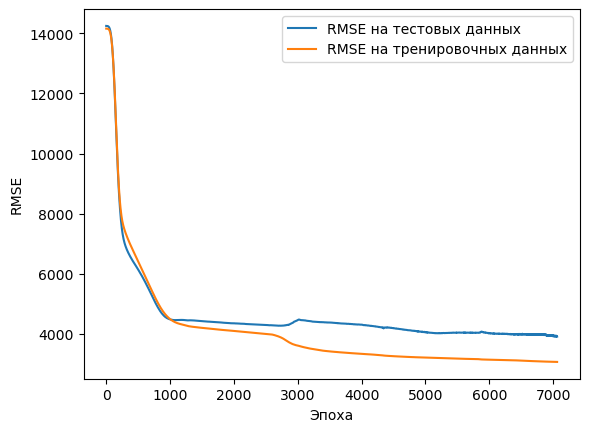

In [34]:
plt.plot(test_loss_list, label='RMSE на тестовых данных')
plt.plot(train_loss_list, label='RMSE на тренировочных данных')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.legend()
plt.show()

 **Вывод:** Из полученного графика мы видим, что наилучшая эпоха обучения 7061, далее наблюдается переобучение модели. Поэтому количество эпох надо ограничить 7062. RMSE на тестовой выборке 3915.221435546875, на обучающей выборке 3070.520751953125, что соответсвует условию задачи.

### Функция для построения графика температур факт-прогноз

In [35]:
def fact_forecast(test_preds, y_test):
    
    '''Функция для визуализации качества предсказания температуры звезд "Факт-прогноз"'''
    
    
    y1 = test_preds.detach().numpy() 
    y2 = y_test.detach().numpy() 
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
    forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()

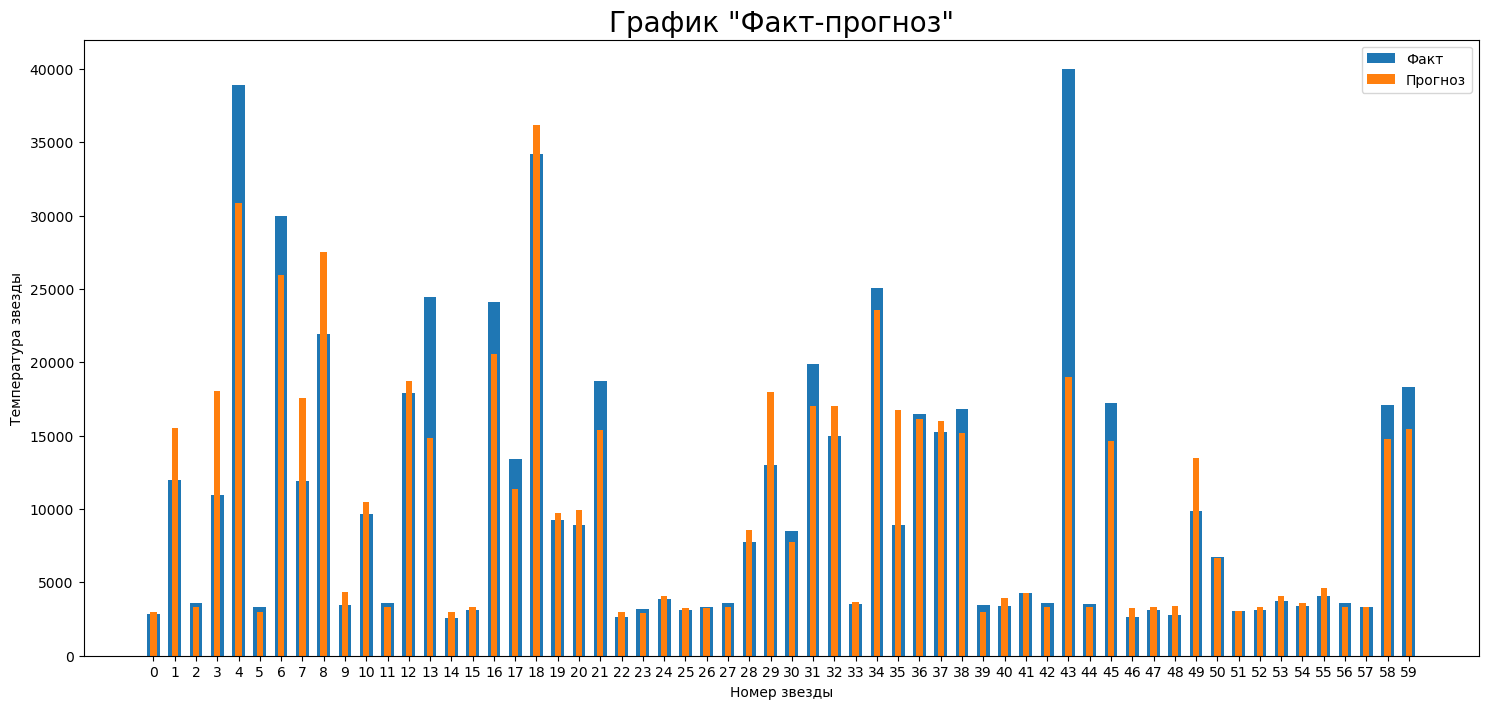

In [36]:
fact_forecast(best_preds, y_test)

**Вывод:** На данном этапе попробывали подобрать число нейронов во внутренних слоях нейронной сети и, обучив модель, оценить результаты. 

Были рассммотрены следующие варианты:

Число нейронов на первойм скрытом слое 15, на втором скрытом слое 10:
- rmse на тестовой выборке - 4254
- rmse на обучающей выборке - 3953

Число нейронов на первойм скрытом слое 20 на втором скрытом слое 20:
- rmse на тестовой выборке - 4230
- rmse на обучающей выборке - 3958

Число нейронов на первойм скрытом слое 12 на втором скрытом слое 8:
- rmse на тестовой выборке - 4234
- rmse на обучающей выборке - 3952

И представленный в коде вариант, который оказался самым лучшиим из рассматриваемых.
Число нейронов на первойм скрытом слое 20 на втором скрытом слое 15:
- rmse на тестовой выборке - 3915.22
- rmse на обучающей выборке - 3070.52

Это соответсвует условтию задачи - метрика RMSE не должна превышать 4500.
В дальнейшем будем работать с данной архитектурой модели и попробуем улучшить ее результаты.

## Улучшение сети


На данном этапе попробуем улучшить модель, применив обучение с разбивкой на батчи и использовав технику «dropout».

### Напишем функцию для обучения сети с разбивкой на батчи

In [37]:
def net_train (net, x_train, x_test, batch_size, num_epochs, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MSELoss() 
    num_epochs = num_epochs
    batch_size = batch_size
    best_rmse = 20000
    num_batches = ceil(len(x_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(x_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx*batch_size
            optimizer.zero_grad()
            batch_index = order[start_index:start_index+batch_size]
            x_batch = x_train[batch_index]
            y_batch = y_train[batch_index]
            train_preds = net.forward(x_batch).flatten()
            train_loss = loss(train_preds, y_batch)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
 
        net.eval()
        test_preds = net.forward(x_test).flatten()
        test_loss = loss(test_preds, y_test)
        rmse_test = torch.sqrt(test_loss).item()
        rmse_train = torch.sqrt(train_loss).item()
    
        if rmse_test < best_rmse:
            best_rmse = rmse_test
            best_epoch = epoch
            loss_train = rmse_train
            best_preds = test_preds
    print(f'Best_epoch {best_epoch}, Best RMSE train {loss_train}, Best RMSE test {best_rmse}')

In [38]:
p = [0.3, 0.5]
batch_size = [40, 50]

for i in p:
    class DropoutNeuralNet(nn.Module):
        def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
            super(DropoutNeuralNet, self).__init__()
            self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
            self.drop1 = nn.Dropout(p=i)
            self.ac1 = nn.ReLU()
            self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
            self.ac2 = nn.ReLU()
            self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
            
    
        def forward(self, x):
            x = self.fc1(x)
            x = self.drop1(x)
            x = self.ac1(x)
            x = self.fc2(x)
            x = self.ac2(x)
            x = self.fc3(x)
            
            return x
    net_2 = DropoutNeuralNet(x_train.shape[1], 20, 15, 1)
    for batch in batch_size:
        print('p=', i, 'batch_size=', batch)
        net_train (net = net_2 , x_train =  x_train, x_test =  x_test, batch_size = batch, num_epochs = 10000, lr=0.01)

p= 0.3 batch_size= 40
Best_epoch 743, Best RMSE train 5689.85791015625, Best RMSE test 4171.89306640625
p= 0.3 batch_size= 50
Best_epoch 673, Best RMSE train 3244.5908203125, Best RMSE test 4851.1162109375
p= 0.5 batch_size= 40
Best_epoch 1036, Best RMSE train 3161.998291015625, Best RMSE test 4147.91455078125
p= 0.5 batch_size= 50
Best_epoch 555, Best RMSE train 3402.12158203125, Best RMSE test 4680.763671875


### Из рассмотренных вариантов лучший - p= 0.5 batch_size= 40, RMSE train 3161.998291015625, Best RMSE test 4147.91455078125, Best_epoch 1036

In [43]:
class DropoutNeuralNet(nn.Module):
        def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
            super(DropoutNeuralNet, self).__init__()
            self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
            self.drop1 = nn.Dropout(p=0.5)
            self.ac1 = nn.ReLU()
            self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
            self.ac2 = nn.ReLU()
            self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
            
    
        def forward(self, x):
            x = self.fc1(x)
            x = self.drop1(x)
            x = self.ac1(x)
            x = self.fc2(x)
            x = self.ac2(x)
            x = self.fc3(x)
            
            return x

In [40]:
net_3 = DropoutNeuralNet(x_train.shape[1], 20, 15, 1)

In [41]:
optimizer = torch.optim.Adam(net_3.parameters(), lr=0.01)
loss = nn.MSELoss() 

num_epochs = 10000
batch_size = 40
best_rmse = 20000
num_batches = ceil(len(x_train)/batch_size)
for epoch in range(num_epochs):
    order = np.random.permutation(len(x_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx*batch_size
        optimizer.zero_grad()
        batch_index = order[start_index:start_index+batch_size]
        x_batch = x_train[batch_index]
        y_batch = y_train[batch_index]
        train_preds = net_3.forward(x_batch).flatten()
        train_loss = loss(train_preds, y_batch)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
    net_3.eval()
    test_preds = net_3.forward(x_test).flatten()
    test_loss = loss(test_preds, y_test)
    rmse_test = torch.sqrt(test_loss).item()
    rmse_train = torch.sqrt(train_loss).item()
    
    
    if rmse_test < best_rmse:
        best_rmse_1 = rmse_test
        best_epoch_1 = epoch
        loss_train_1 = rmse_train
        best_preds_1 = test_preds
print(f'Best_epoch {best_epoch_1}, Best RMSE train {loss_train_1}, Best RMSE test {best_rmse_1}')

Best_epoch 9999, Best RMSE train 3403.487060546875, Best RMSE test 4372.892578125


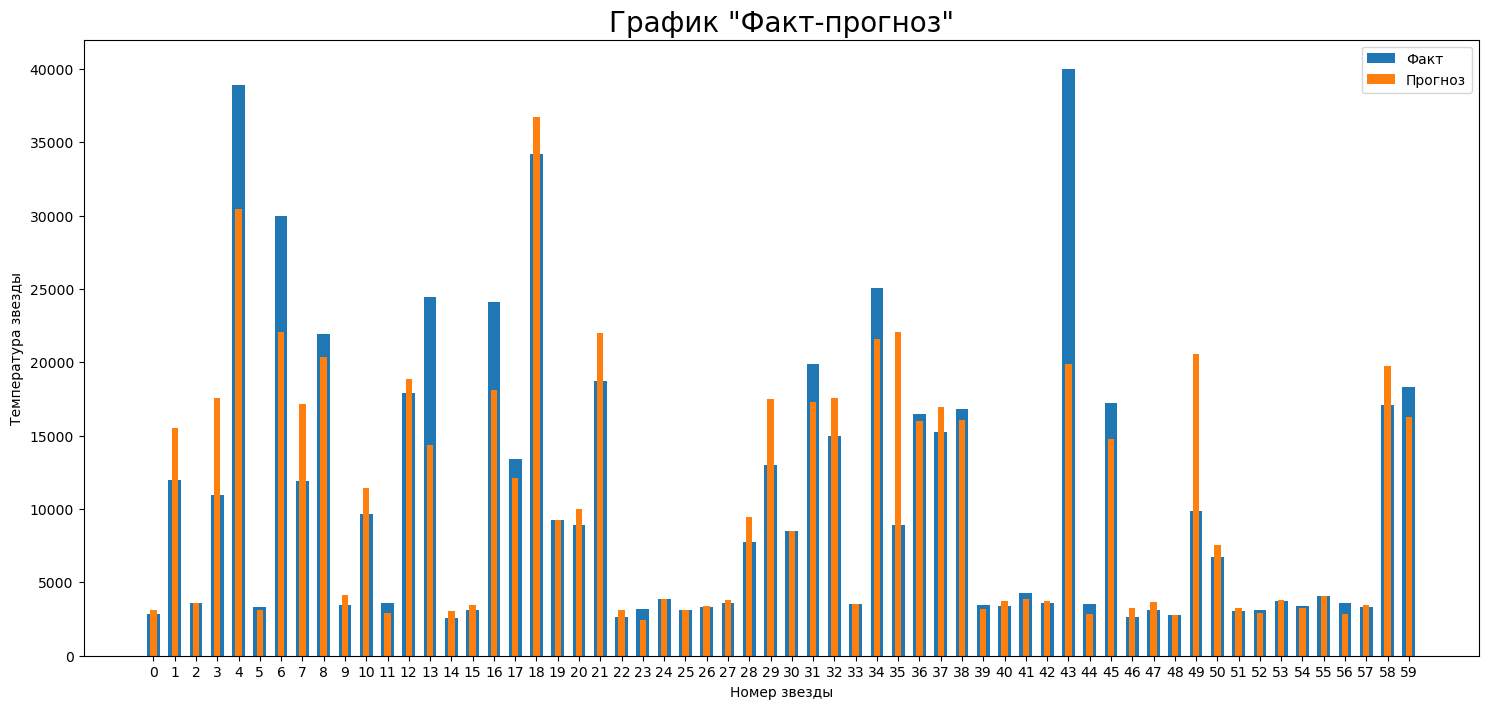

In [42]:
fact_forecast(best_preds_1, y_test)

**Вывод**
Улучшить результаты нейронной сети путем добавления обучения с разбивкой на батчи и использованием «dropout» не удалось, показание метрики rmse  ухудшилось - 4308.56298828125 против 3915.221435546875 на нейронной сети без обучения с разбивкой на батчи и использованием «dropout». 

**Итоговый вывод:**
В процессе выполнения работы было сделано следующее:

1. Прведена загрузчка и первоначальное изучение данных -  Размер дата фрейма - 240 строк на 7 столбцов. Явных дубликатов и пропусков в данных нет.  Из матрицы корреляции видно, что есть два мультиколлениарных признака Star type и Absolute magnitude. В столбцах Temperature(K), Luminosity(L/Lo), Radius(R/Ro) - наблюдаются выбросы. Распределение количественных признаков не относитсмя к нормальномую. Изменили тип данных с столбце с типом звезд, убрали из названия столбцов пропуски, удалили столбец Unnamed: 0.

2. Прроведен анали данных - На данном этапе были более подробно рассмотрены следующие признаки:

star_type - Категриальный признак. В данном признаке 6 типов звезд, по 40 звезд в каждой категории.

star_сolor - Удалили неявные дубликаты, сократив количество уникальных значений в данном столбце с 19 до 11. Данный признак относится к категориальным. Наибольшее количество звезд в датасете относится к категории красных, затем следуют синие(голубые) и бело-голубые. Наименьшее количество звезд относится к категориям pale-yellow-orange и orange-red. Несмотря на то, что данных в этих категориях мало, оставляем их, т.к. в целом данных для обучения немного, такие градации цвета есть, и по ним также надо предсказывать температуру.

temperature_k - Целевой признак. Данные, в том числе попадающие в зону выбрасов, выглядят правдоподобно, поэтому все данные были оставлены.

luminosityr, radius - Количественные признаки. Данные, в том числе попадающие в зону выбрасов, выглядят правдоподобно, поэтому все данные были оставлены.

3. Подготовка данных  - На данном этапе с помощью метода train_test_split() данные были разделены на обучающую и тестовую выборки и соответсвующие им разбиение целевого признака. Выделены категориальные и количественные признаки. С помощью StandardScaler() произведено масштабирование количественных признаков. С помощью OneHotEncoder проведено кодирование категориальных признаков. Перевели полученные выборки в тензоры.

4. Построение простой модели нейронной сети — baseline.
Были рассммотрены следующие варианты:

Число нейронов на первойм скрытом слое 15, на втором скрытом слое 10:

rmse на тестовой выборке - 4254
rmse на обучающей выборке - 3953

Число нейронов на первойм скрытом слое 20 на втором скрытом слое 20:

rmse на тестовой выборке - 4230
rmse на обучающей выборке - 3958

Число нейронов на первойм скрытом слое 12 на втором скрытом слое 8:

rmse на тестовой выборке - 4234
rmse на обучающей выборке - 3952

И представленный в коде вариант, который оказался самым лучшиим из рассматриваемых. Число нейронов на первойм скрытом слое 20 на втором скрытом слое 15:

rmse на тестовой выборке - 3915.22
rmse на обучающей выборке - 3070.52

Данные показатели соответсвуют условию задачи - Метрика RMSE не должна превышать 4500.
В дальнейшем будем работать с данной архитектурой модели и попробуем улучшить ее результаты.

5. Улучшение результатов работы сети - Улучшить результаты нейронной сети путем добавления обучения с разбивкой на батчи и использованием «dropout» не удалось, показание метрики rmse  ухудшилось - 4308.56298828125 против 3915.221435546875 на нейронной сети без обучения с разбивкой на батчи и использованием «dropout».

Таким образом лучшим вариантом сети с rmse на тестовой выборке = 3915.22 оказалась сеть net со следующими параметрами:
net = Net(18, 20, 15, 1), обученная без разбиения на батчи и использолвания «dropout»    